# Stacking Ensemble 
### 결과
- 아래처럼 기대했으나 결과는 더 안좋았다. catboost가 특정구간의 데이터셋이 부족했는지 or 특성이 부족했는지 같은수치의 예측물들만 출력했다.

### 방향성
- lstm과 cnn의 결과물에서 3일분정도를 앞당겨보려고한다. 그리고 다른셋에 적용시켰을때도 안되면,
- 분류모델에 집중해서 voting으로 앙상블한다. 주가의 상승/하락 분류

### 기대
- lstm,cnn을 boost알고리즘과 앙상블하려면, 1. 부스팅알고리즘만 사용하던가, 2. 스태킹앙상블하던가 
- 평가차트를보면 실제주가데이터보다 살짝 이틀?정도 밀려서 예측을하는데, 그럼 스태킹앙상블해서 캣부스트로 넣으면 이러한 패턴을 읽고 어느정도 보완해서 정확히 예측할수있지않을까?
- 예를들면 이런거지. 실제주가데이터가 4,3,2,3,5,7순서라면, lstm,cnn은 4,4,3,2,2,3,5,8이런식으로 한발짝 늦게가니까, 이러한 패턴을 스태킹앙상블 캣부스트가 잡아주지않을까?

## 데이터셋 정규화/전처리

In [1]:
import yfinance
import numpy as np
import tensorflow as tf
import os

# Original datasetb
df = yfinance.download('AAPL','2000-1-1','2020-1-1')
df = df.drop(['Volume'],1).drop(['Adj Close'],1)
display(df)

# 정규화 0~1
def normalize_data(dataset):
    cols = dataset.columns.tolist()
    # 편의상 모든컬럼명을 인덱스(실수)로 바꿈
    col_name = [0]*len(cols)          # [0, 0, 0, 0]
    for i in range(len(cols)):
        col_name[i] = i               # [0, 1, 2, 3]
    dataset.columns = col_name
    dtypes = dataset.dtypes.tolist()
    minmax = list()
    for column in dataset:
        dataset = dataset.astype({column: 'float32'})
    # 각 컬럼의 min, max 저장(정규화를 위함)
    for i in range(len(cols)):
        col_values = dataset[col_name[i]]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    # 0~1사이값으로 정규화
    for column in dataset:
        values = dataset[column].values
        for i in range(len(values)):
            values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
        dataset[column] = values
    dataset[column] = values
    return dataset,minmax
    

dataset, minmax = normalize_data(df)
values = dataset.values
display("< original df >", df.head(21), "< nomalized dataset >", dataset.head(21))
# 종가 예측은 11번째부터 시작 (1.18일부터)

def split_sequences(sequence, n_steps):
    X,y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1: 
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # 오프셋 정렬
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    

def data_setup(n_steps, sequence):
    X, y = split_sequences(sequence, n_steps)
    # print("< X > \n",X[:2],X.shape)                   # X : 10일분의 데이터묶음이 5021개
    # print("< y > \n",y[:2],y.shape)                   # y : X의 각 묶음의 마지막날의 다음날데이터(예측할 타겟)
    n_features = X.shape[2]                       # X의 피쳐(특성) 수
    X = X.reshape((len(X), n_steps, n_features))  # 형태재구성 (샘플 수, 시퀀스 길이, 특성 수)
    # 
    new_y = []
    for term in y:
        new_term = term[-1]                       # 종가 컬럼만 추출
        new_y.append(new_term)
    return X, np.array(new_y), n_features

n_steps = 10        # 10일 분량
rel_test_len = 0.1  # 트 : 테 = 9 : 1
X,y,n_features = data_setup(n_steps, values)


X_test, y_test =  X[:int(len(X) * rel_test_len)], y[:int(len(X) * rel_test_len)]
X_train, y_train = X[int(len(X) * rel_test_len):], y[int(len(X) * rel_test_len):]

print(" < final y > \n",y[:10], y.shape)
print("< n_features >\n",n_features)

# array([0.9280131 , 0.95145106, 1.013393  , 0.99386203, 0.948661  ,
#        1.002232  , 0.98381704, 0.982143  , 0.907366  , 0.92633903],

[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_17188/3135173666.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_17188/3135173666.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)


,Open,High,Low,Close
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497
2019-12-26,71.205002,72.495003,71.175003,72.477501
2019-12-27,72.779999,73.492500,72.029999,72.449997


'< original df >'

,0,1,2,3
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
2000-01-10,0.910714,0.912946,0.845982,0.872768
2000-01-11,0.856585,0.887277,0.808036,0.828125
2000-01-12,0.848214,0.852679,0.772321,0.778460
2000-01-13,0.843610,0.881696,0.825893,0.863839


'< nomalized dataset >'

,0,1,2,3
Date,,,,
2000-01-03,0.009710,0.010496,0.009435,0.010456
2000-01-04,0.010125,0.010268,0.009373,0.009305
2000-01-05,0.009571,0.010260,0.009598,0.009488
2000-01-06,0.009864,0.009826,0.008608,0.008389
2000-01-07,0.008679,0.009095,0.008670,0.008939
2000-01-10,0.009356,0.009247,0.008577,0.008725
2000-01-11,0.008610,0.008897,0.008051,0.008115
2000-01-12,0.008494,0.008424,0.007556,0.007436
2000-01-13,0.008431,0.008820,0.008298,0.008603


 < final y > 
 [0.00947997 0.00980025 0.01064671 0.01037981 0.00976213 0.01049419
 0.01024254 0.01021967 0.00919782 0.00945709] (5021,)
< n_features >
 4


# 모델 로드

In [2]:
import os
from keras.models import load_model, model_from_json

def load_keras_model(optimizer, loss, dirx,json,h5):
    os.chdir(dirx)
    json_file = open(json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss = loss)
    model.load_weights(h5)
    return model

lstm_dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/models'
lstm_json, lstm_h5 = 'LSTM_network.json', 'LSTM_weights.h5'
CNN_dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test'
CNN_json, CNN_h5 = 'Tuned_CNN.json', 'Tuned_CNN_weights.h5'
optimizer = 'adam'
loss = 'mse'

# Model load
LSTM_model = load_keras_model(optimizer,loss, lstm_dirx, lstm_json, lstm_h5)
CNN_model = load_keras_model(optimizer,loss, CNN_dirx, CNN_json, CNN_h5)

Metal device set to: Apple M2 Pro


2024-01-23 20:19:29.993626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-23 20:19:29.994067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
from sklearn.metrics import mean_squared_error

# 두 모델의 예측 결과 계산
lstm_predictions = LSTM_model.predict(X_train)
cnn_predictions = CNN_model.predict(X_train)
lstm_predictions_test = LSTM_model.predict(X_test)
cnn_predictions_test = CNN_model.predict(X_test)

print("[ 손실함수 ]")
LSTM_mse = mean_squared_error(y_train, lstm_predictions)
print("LSTM MSE:", LSTM_mse)
CNN_mse = mean_squared_error(y_train, cnn_predictions)
print("CNN MSE:", CNN_mse)

16/16 [==============================] - 0s 2ms/step
[ 손실함수 ]
LSTM MSE: 2.797433e-05
CNN MSE: 2.9892224e-05


# 스태킹앙상블 학습데이터셋

In [30]:
from catboost import CatBoostRegressor
import pandas as pd
# LSTM과 CNN 모델의 예측 결과를 합침
# Train set
stacked_predictions = np.column_stack((lstm_predictions, cnn_predictions))

# Test set
stacked_pred_test = np.column_stack((lstm_predictions_test, cnn_predictions_test))

# stacked_predictions 배열을 데이터프레임으로 변환
df_stacked_pred = pd.DataFrame(stacked_predictions, columns=['LSTM', 'CNN'])
sr_y_train = pd.Series(y_train)
display(df_stacked_pred,sr_y_train)
display(stacked_pred_test)

,LSTM,CNN
0,0.002147,0.002531
1,0.002111,0.002506
2,0.002082,0.002511
3,0.002070,0.002581
4,0.002078,0.002640
...,...,...
4514,0.964791,0.952443
4515,0.966763,0.957116
4516,0.972185,0.965851
4517,0.975037,0.972840


0       0.002208
1       0.002123
2       0.002416
3       0.002462
4       0.002472
          ...   
4514    0.967955
4515    0.987223
4516    0.986847
4517    0.992723
4518    1.000000
Length: 4519, dtype: float32

array([[0.00838716, 0.0092234 ],
       [0.00826241, 0.00947768],
       [0.00820987, 0.00976815],
       ...,
       [0.00222   , 0.00254729],
       [0.00220974, 0.00252967],
       [0.00217989, 0.00244241]], dtype=float32)

# CatBoost

In [40]:
# 하이퍼파라미터튜닝
# 옵튜나 + k-fold
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import numpy as np
import optuna
from functools import partial


def Cat_optimizer(trial, X, y, K):

    iterations = trial.suggest_int('iterations', 5, 5000)
    depth = trial.suggest_int('depth', 1, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    border_count = trial.suggest_int('border_count', 8, 255)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 30)
    one_hot_max_size = trial.suggest_int('one_hot_max_size', 1, 500)
    l2_leaf_reg = trial.suggest_float('leaf_reg', 1, 10)

    # 아래 파라미터들은 제안된 값이 고정값이므로, suggest 메서드를 사용하지 않고 직접 값을 할당합니다.
    bootstrap_type = "Bayesian"
    sampling_frequency = "PerTreeLevel"
    random_state = 42
    early_stopping_rounds = 50

    model = CatBoostRegressor(iterations=iterations,
                              depth=depth,
                              learning_rate=learning_rate,
                              border_count=border_count,
                              min_data_in_leaf=min_data_in_leaf,
                              one_hot_max_size=one_hot_max_size,
                              l2_leaf_reg=l2_leaf_reg,
                              bootstrap_type=bootstrap_type,
                              sampling_frequency=sampling_frequency,
                              random_state=random_state,
                              verbose=0,
                              early_stopping_rounds=early_stopping_rounds)
    
    # K-Fold Cross validation
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        # Pool 형식으로 데이터 변환
        train_pool = Pool(X_train, y_train)
        val_pool = Pool(X_val, y_val)

        # fit 함수에서 사용
        model.fit(train_pool, eval_set=val_pool)  # 학습 중 eval_set으로 검증 데이터 사용
        #model.fit(X_train, y_train)
        preds = np.clip(model.predict(X_val), 0, None) # np.clip 함수를 사용하여 예측 값을 0 이상으로 제한 : RMSLE는 양수값만 검증가능
        loss = mean_squared_error(y_val, preds) # MSE
        print(f"MSE : {loss}")
        losses.append(loss)
    
    
    # K-Fold - loss return
    return np.mean(losses)

K = 10  # train data를 5등분하여 5회 학습 (train : val = 4 : 1)
opt_func = partial(Cat_optimizer, X=df_stacked_pred, y=sr_y_train, K=K)

study = optuna.create_study(direction="minimize") # 손실함수(MSE) -> minimize

study.optimize(opt_func, n_trials=50)

# Find Best params
study.trials_dataframe() # dataframe of optuna activities
best_params = study.best_trial.params
print("Best Score: %.5f" % study.best_value) # best score print
print("Best params: ", best_params) # best params


[I 2024-01-23 21:40:13,541] A new study created in memory with name: no-name-3406eed6-83b3-4f41-8071-0c25f9f767f3


MSE : 1.8173585492906416e-05
MSE : 2.645353557859034e-05
MSE : 3.0273679927932156e-05
MSE : 6.834289263409402e-05
MSE : 0.0005227347079981281
MSE : 0.00039924138533681784
MSE : 0.00017740759823163557
MSE : 0.0006752326200767941
MSE : 0.0001890240006402614


[I 2024-01-23 21:40:14,480] Trial 0 finished with value: 0.0019363668647655718 and parameters: {'iterations': 4727, 'depth': 1, 'learning_rate': 0.22062833644954188, 'border_count': 224, 'min_data_in_leaf': 4, 'one_hot_max_size': 426, 'leaf_reg': 5.526038829108426}. Best is trial 0 with value: 0.0019363668647655718.


MSE : 0.01725678464173856
MSE : 1.2071909794620517e-06
MSE : 5.761525550007468e-05
MSE : 5.338068796578916e-05
MSE : 3.314747620020586e-05
MSE : 0.00027805750160482344
MSE : 0.00024949108733164264
MSE : 0.00010955948018020368
MSE : 0.0001761000007376777
MSE : 0.0004345677849070618


[I 2024-01-23 21:40:15,375] Trial 1 finished with value: 0.0018205647705475995 and parameters: {'iterations': 1870, 'depth': 8, 'learning_rate': 0.4486468522321407, 'border_count': 107, 'min_data_in_leaf': 5, 'one_hot_max_size': 128, 'leaf_reg': 2.2890582630598137}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.016812521240069055
MSE : 1.2290177785637033e-06
MSE : 3.219880581193023e-05
MSE : 2.7186432772384088e-05
MSE : 1.9655660913718468e-05
MSE : 0.00028046609423944
MSE : 0.00023772796224714795
MSE : 0.00010515304449553015
MSE : 0.00010451899095631201
MSE : 0.000262062784937477


[I 2024-01-23 21:40:20,167] Trial 2 finished with value: 0.0018404320396739643 and parameters: {'iterations': 1562, 'depth': 10, 'learning_rate': 0.1286216933456417, 'border_count': 187, 'min_data_in_leaf': 9, 'one_hot_max_size': 230, 'leaf_reg': 9.432790324354839}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.01733412160258714
MSE : 8.407691870740678e-05
MSE : 3.597088083290252e-05
MSE : 7.168805537752118e-05
MSE : 0.0002792276564657849
MSE : 0.0017587116096897842
MSE : 0.000348427055748968
MSE : 0.0007265799677225378
MSE : 0.0016585417380930577
MSE : 0.0014306894176023786


[I 2024-01-23 21:40:20,834] Trial 3 finished with value: 0.003800744520214406 and parameters: {'iterations': 4811, 'depth': 5, 'learning_rate': 0.07358210346480623, 'border_count': 13, 'min_data_in_leaf': 20, 'one_hot_max_size': 456, 'leaf_reg': 7.986316993099787}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.03161353190190372
MSE : 3.4203486025061127e-07
MSE : 2.8500031528570233e-05
MSE : 2.6179669133314446e-05
MSE : 1.4778786290553167e-05
MSE : 0.0003147827851094533
MSE : 0.00014091644976788447
MSE : 0.00010175823660719024
MSE : 0.00015285832117370058
MSE : 0.00023831482994551438


[I 2024-01-23 21:40:23,311] Trial 4 finished with value: 0.0018352420457175625 and parameters: {'iterations': 2426, 'depth': 9, 'learning_rate': 0.08131793893712692, 'border_count': 169, 'min_data_in_leaf': 15, 'one_hot_max_size': 254, 'leaf_reg': 7.228627825558469}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.017333989312759195
MSE : 7.864109755192064e-06
MSE : 2.5343370221311244e-05
MSE : 5.650893151277138e-05
MSE : 4.4532712048847646e-05
MSE : 0.0004335635187508815


[I 2024-01-23 21:40:23,742] Trial 5 finished with value: 0.0020636108163156097 and parameters: {'iterations': 212, 'depth': 2, 'learning_rate': 0.4738821464454842, 'border_count': 61, 'min_data_in_leaf': 8, 'one_hot_max_size': 131, 'leaf_reg': 3.270603525590903}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.00016930592020065186
MSE : 0.0002617867427908252
MSE : 0.00017574970280148931
MSE : 0.0007013585041508174
MSE : 0.01876009465092331
MSE : 4.8585266710847186e-06
MSE : 4.988667786210485e-05
MSE : 4.273490285419194e-05
MSE : 2.3775562909992787e-05
MSE : 0.00031057806402140005
MSE : 0.00013533334906466887
MSE : 0.00012629539581115025
MSE : 0.00020314035970350045
MSE : 0.00039475018290664006


[I 2024-01-23 21:40:25,061] Trial 6 finished with value: 0.0018622684221222545 and parameters: {'iterations': 2578, 'depth': 9, 'learning_rate': 0.40335193172381495, 'border_count': 87, 'min_data_in_leaf': 15, 'one_hot_max_size': 140, 'leaf_reg': 9.904391446594516}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.01733133119941781
MSE : 2.032517681326447e-06
MSE : 5.9996554553531235e-05
MSE : 3.2402303778157244e-05
MSE : 2.042125154032306e-05
MSE : 0.00037162754642370535
MSE : 0.00024554521156308325
MSE : 0.00012031422142445451
MSE : 0.00017907825492529563


[I 2024-01-23 21:40:25,629] Trial 7 finished with value: 0.0018765719965694986 and parameters: {'iterations': 1357, 'depth': 4, 'learning_rate': 0.434196590716508, 'border_count': 107, 'min_data_in_leaf': 20, 'one_hot_max_size': 148, 'leaf_reg': 1.9968511062933199}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.0004187465036178325
MSE : 0.017315555600187278
MSE : 4.690439476090407e-07
MSE : 2.6033209533608356e-05
MSE : 3.8505918397226715e-05
MSE : 2.3555440413584813e-05
MSE : 0.0003128751874958719
MSE : 0.00013522495322442228
MSE : 0.00018216962937511548
MSE : 0.0001786671309016701
MSE : 0.000517263246175827


[I 2024-01-23 21:40:26,429] Trial 8 finished with value: 0.0020152953477690794 and parameters: {'iterations': 2979, 'depth': 6, 'learning_rate': 0.3022776671470106, 'border_count': 82, 'min_data_in_leaf': 26, 'one_hot_max_size': 347, 'leaf_reg': 6.320352686399811}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.01873818971822586
MSE : 3.5644487743423333e-05
MSE : 2.585573594717624e-05
MSE : 4.2116770015014914e-05
MSE : 0.0002463971112052155
MSE : 0.0006233999458167757
MSE : 0.0004496522547653811


[I 2024-01-23 21:40:27,139] Trial 9 finished with value: 0.0021340237290684446 and parameters: {'iterations': 3598, 'depth': 1, 'learning_rate': 0.3230571220058002, 'border_count': 176, 'min_data_in_leaf': 22, 'one_hot_max_size': 456, 'leaf_reg': 5.805281344426469}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.0001423185264487505
MSE : 0.0011249864781263412
MSE : 0.00031290201699043146
MSE : 0.018336963963625937
MSE : 3.1898171219913005e-06
MSE : 3.378943020650835e-05
MSE : 2.3704955139555022e-05
MSE : 1.7622848620403158e-05
MSE : 0.00025456381982813905
MSE : 0.0001773100190327997
MSE : 0.00011545767277616665
MSE : 0.00013936553829925014
MSE : 0.0003049094090614048


[I 2024-01-23 21:40:33,283] Trial 10 finished with value: 0.001840057756993242 and parameters: {'iterations': 222, 'depth': 12, 'learning_rate': 0.20018989543038823, 'border_count': 135, 'min_data_in_leaf': 6, 'one_hot_max_size': 42, 'leaf_reg': 3.5844310984371273}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.0173306640598462
MSE : 2.701083051151993e-06
MSE : 4.475030256635012e-05
MSE : 2.474299638496213e-05
MSE : 1.3837549105336841e-05
MSE : 0.0002640454149686754
MSE : 0.0001837872053152933
MSE : 9.812034329354384e-05
MSE : 0.00013387615969728868
MSE : 0.00023288676901359696


[I 2024-01-23 21:40:40,512] Trial 11 finished with value: 0.0018343493666548474 and parameters: {'iterations': 1626, 'depth': 8, 'learning_rate': 0.013027342282879648, 'border_count': 140, 'min_data_in_leaf': 13, 'one_hot_max_size': 288, 'leaf_reg': 7.263857734513036}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.017344745843152275
MSE : 6.971479183320883e-07
MSE : 4.5436367500422444e-05
MSE : 2.3374744184531124e-05
MSE : 1.75820564847342e-05
MSE : 0.00025675909290773284
MSE : 0.00018323475780286308
MSE : 9.981718191233963e-05
MSE : 0.00011762627962068712
MSE : 0.00021366138459889765


[I 2024-01-23 21:40:45,075] Trial 12 finished with value: 0.0018289583668659327 and parameters: {'iterations': 1460, 'depth': 8, 'learning_rate': 0.022475506889205597, 'border_count': 136, 'min_data_in_leaf': 1, 'one_hot_max_size': 298, 'leaf_reg': 1.1572478253750944}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.017331394655728787
MSE : 2.6452637601732646e-06
MSE : 2.7254459828255842e-05
MSE : 4.285167933344409e-05
MSE : 6.711846326976496e-05
MSE : 0.000336347922023075
MSE : 0.0002277802775225217
MSE : 0.00020407167586105043
MSE : 0.0008537852401936962


[I 2024-01-23 21:40:46,030] Trial 13 finished with value: 0.0021388112740552746 and parameters: {'iterations': 904, 'depth': 7, 'learning_rate': 0.36400479241117917, 'border_count': 46, 'min_data_in_leaf': 1, 'one_hot_max_size': 50, 'leaf_reg': 1.2498087765679882}. Best is trial 1 with value: 0.0018205647705475995.


MSE : 0.000855213771266851
MSE : 0.01877104398749391
MSE : 1.0963151750178623e-06
MSE : 2.6226885040578333e-05
MSE : 1.4121608799647961e-05
MSE : 1.5427385511946615e-05
MSE : 0.00028507344364893253
MSE : 0.00011159224635082399
MSE : 4.957164445108074e-05
MSE : 8.152996193693256e-05
MSE : 0.00014805275518821467


[I 2024-01-23 21:40:57,001] Trial 14 finished with value: 0.0017525354616142446 and parameters: {'iterations': 2097, 'depth': 12, 'learning_rate': 0.16610440917908093, 'border_count': 249, 'min_data_in_leaf': 1, 'one_hot_max_size': 361, 'leaf_reg': 3.46127441997064}. Best is trial 14 with value: 0.0017525354616142446.


MSE : 0.01679266237003927
MSE : 4.274127534738777e-06
MSE : 2.600693405553654e-05
MSE : 2.3218963378832902e-05
MSE : 1.3712927763060157e-05
MSE : 0.0002750808186208663
MSE : 0.00011340596801536784
MSE : 5.2553257435869636e-05
MSE : 0.0001165356725888762
MSE : 0.0001108114243951668


[I 2024-01-23 21:41:07,250] Trial 15 finished with value: 0.001751746123404631 and parameters: {'iterations': 3698, 'depth': 12, 'learning_rate': 0.16540328818791084, 'border_count': 246, 'min_data_in_leaf': 10, 'one_hot_max_size': 348, 'leaf_reg': 4.004971904539096}. Best is trial 15 with value: 0.001751746123404631.


MSE : 0.01678186114025799
MSE : 1.6845610472026412e-06
MSE : 2.5298810965397582e-05
MSE : 1.277490369410292e-05
MSE : 1.8892918573019164e-05
MSE : 0.00025284478284562026
MSE : 0.0001294386164735985
MSE : 6.141857739701769e-05
MSE : 9.012312863433183e-05
MSE : 0.00014417239646458683


[I 2024-01-23 21:41:12,868] Trial 16 finished with value: 0.0017536904806193577 and parameters: {'iterations': 3914, 'depth': 11, 'learning_rate': 0.18184049377929748, 'border_count': 253, 'min_data_in_leaf': 11, 'one_hot_max_size': 375, 'leaf_reg': 4.308313705579728}. Best is trial 15 with value: 0.001751746123404631.


MSE : 0.0168002561100987
MSE : 2.790857930041254e-06
MSE : 2.510789677067643e-05
MSE : 1.1821559095103235e-05
MSE : 1.2229491991538063e-05
MSE : 0.00023629226680631598
MSE : 0.00013056683192416352
MSE : 5.857441705067686e-05
MSE : 8.190567638193939e-05
MSE : 0.00012965343250078071


[I 2024-01-23 21:41:26,044] Trial 17 finished with value: 0.0017486429475135627 and parameters: {'iterations': 3612, 'depth': 12, 'learning_rate': 0.14796190567729126, 'border_count': 254, 'min_data_in_leaf': 30, 'one_hot_max_size': 386, 'leaf_reg': 4.721225034941601}. Best is trial 17 with value: 0.0017486429475135627.


MSE : 0.01679748704468439
MSE : 2.2227726874627267e-06
MSE : 2.5936076803300648e-05
MSE : 2.4699491560890044e-05
MSE : 1.5667014677583853e-05
MSE : 0.0003616341920562391
MSE : 0.00011598897729686965
MSE : 8.490434970150972e-05
MSE : 0.00014149869511038767
MSE : 0.00016927308484764877


[I 2024-01-23 21:41:31,553] Trial 18 finished with value: 0.001772318715684077 and parameters: {'iterations': 3792, 'depth': 11, 'learning_rate': 0.26501881515004133, 'border_count': 220, 'min_data_in_leaf': 30, 'one_hot_max_size': 388, 'leaf_reg': 4.514380628492007}. Best is trial 17 with value: 0.0017486429475135627.


MSE : 0.016781362502098877
MSE : 1.4727435904641362e-06
MSE : 2.5271453905300962e-05
MSE : 2.404290408112269e-05
MSE : 1.1361805651470692e-05
MSE : 0.0002938375310718579
MSE : 0.00022879161666348395
MSE : 6.819137527686417e-05
MSE : 0.00012528962116147867
MSE : 0.0001748566100096741


[I 2024-01-23 21:41:36,413] Trial 19 finished with value: 0.0017748941944879446 and parameters: {'iterations': 3221, 'depth': 10, 'learning_rate': 0.12171069975129326, 'border_count': 211, 'min_data_in_leaf': 30, 'one_hot_max_size': 204, 'leaf_reg': 4.467557822644805}. Best is trial 17 with value: 0.0017486429475135627.


MSE : 0.01679582628346773
MSE : 2.5784552121287136e-06
MSE : 3.3245088691965994e-05
MSE : 2.3815547604552566e-05
MSE : 1.4713393799794016e-05
MSE : 0.00025733970077370245
MSE : 0.00014688752375786824
MSE : 0.00011424335283084182
MSE : 0.00018755846276064761
MSE : 0.00028671398393572876


[I 2024-01-23 21:41:45,267] Trial 20 finished with value: 0.0017863382919919943 and parameters: {'iterations': 4051, 'depth': 12, 'learning_rate': 0.24533233223570972, 'border_count': 204, 'min_data_in_leaf': 24, 'one_hot_max_size': 490, 'leaf_reg': 5.06796520883085}. Best is trial 17 with value: 0.0017486429475135627.


MSE : 0.016796287410552713
MSE : 8.538788523733122e-07
MSE : 2.536797723671172e-05
MSE : 1.2851249205283374e-05
MSE : 1.4273360535310035e-05
MSE : 0.00023778404624492035
MSE : 0.00011094455366808118
MSE : 6.19964217375794e-05
MSE : 7.89229101004085e-05
MSE : 0.00012885282595044212


[I 2024-01-23 21:41:58,032] Trial 21 finished with value: 0.0017472360356109364 and parameters: {'iterations': 2430, 'depth': 12, 'learning_rate': 0.15538916097579128, 'border_count': 254, 'min_data_in_leaf': 17, 'one_hot_max_size': 344, 'leaf_reg': 3.23052305422566}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016800513132578253
MSE : 2.1972825679816075e-06
MSE : 2.5484974090495018e-05
MSE : 2.5985854927268427e-05
MSE : 1.378102557765418e-05
MSE : 0.00027452107387648865
MSE : 0.00011796386930592468
MSE : 4.730393536048504e-05
MSE : 0.00014466940316667338
MSE : 0.00010148147575928627


[I 2024-01-23 21:42:03,390] Trial 22 finished with value: 0.0017557191032497369 and parameters: {'iterations': 2968, 'depth': 11, 'learning_rate': 0.15362986807120665, 'border_count': 238, 'min_data_in_leaf': 17, 'one_hot_max_size': 293, 'leaf_reg': 2.718958659186323}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.01680380213786511
MSE : 9.44454475012063e-07
MSE : 2.5520842345692953e-05
MSE : 2.6500360830687615e-05
MSE : 1.2453606947697194e-05
MSE : 0.0002534345903152215
MSE : 0.00010124503768687844
MSE : 4.8186219089030374e-05
MSE : 0.00010581825989262785
MSE : 0.00017623834651799326


[I 2024-01-23 21:42:10,290] Trial 23 finished with value: 0.0017541441414070142 and parameters: {'iterations': 4489, 'depth': 10, 'learning_rate': 0.09255590969034444, 'border_count': 235, 'min_data_in_leaf': 18, 'one_hot_max_size': 331, 'leaf_reg': 4.014449434334259}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.0167910996959693
MSE : 4.844091831428508e-06
MSE : 2.526680298748701e-05
MSE : 2.3355070268160545e-05
MSE : 1.3073533719397686e-05
MSE : 0.0002847374607893169
MSE : 0.0001699706069478412
MSE : 5.701732237244706e-05
MSE : 0.00014526167234280897
MSE : 0.0002741361196304242


[I 2024-01-23 21:42:18,974] Trial 24 finished with value: 0.001779432467512185 and parameters: {'iterations': 3211, 'depth': 12, 'learning_rate': 0.2257648754311406, 'border_count': 202, 'min_data_in_leaf': 27, 'one_hot_max_size': 413, 'leaf_reg': 2.7170681526494476}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016796661994232538
MSE : 2.645041630929696e-06
MSE : 2.557307426745592e-05
MSE : 1.526400728178862e-05
MSE : 2.686807788130458e-05
MSE : 0.0002559799066318963
MSE : 0.0001381162896315641
MSE : 4.918506570820806e-05
MSE : 0.00010328177036200973
MSE : 0.0001443120364993613


[I 2024-01-23 21:42:27,102] Trial 25 finished with value: 0.0017548510852835111 and parameters: {'iterations': 4221, 'depth': 11, 'learning_rate': 0.13134120766761193, 'border_count': 250, 'min_data_in_leaf': 12, 'one_hot_max_size': 320, 'leaf_reg': 4.947863031595352}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016787285582940594
MSE : 1.0780217405024398e-06
MSE : 2.5120548629065728e-05
MSE : 2.7749179999423818e-05
MSE : 1.5657364923631697e-05
MSE : 0.00026651480858785854
MSE : 0.00014152834767886509
MSE : 0.00013241425194949365
MSE : 0.00016509288399573296
MSE : 0.0002254580232325728


[I 2024-01-23 21:42:29,649] Trial 26 finished with value: 0.0018328575717535035 and parameters: {'iterations': 3504, 'depth': 10, 'learning_rate': 0.27786863695579817, 'border_count': 156, 'min_data_in_leaf': 27, 'one_hot_max_size': 405, 'leaf_reg': 5.887027390843782}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.017327962286797886
MSE : 2.5899620501888167e-06
MSE : 2.5564585889863173e-05
MSE : 2.9862226385036388e-05
MSE : 2.7456185438391462e-05
MSE : 0.0002939244157386258
MSE : 0.00014946429765483438
MSE : 0.0001033359021501474
MSE : 0.00015433714898013516
MSE : 0.0002759023052786693


[I 2024-01-23 21:42:37,535] Trial 27 finished with value: 0.0018389397177677451 and parameters: {'iterations': 2714, 'depth': 12, 'learning_rate': 0.2048992778745047, 'border_count': 190, 'min_data_in_leaf': 9, 'one_hot_max_size': 500, 'leaf_reg': 6.425611813212939}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.01732696014811156
MSE : 6.432379755044404e-07
MSE : 2.6746306296475804e-05
MSE : 2.5769899239714874e-05
MSE : 2.1958858443914263e-05
MSE : 0.000260491007515978
MSE : 0.00012397291273795658
MSE : 7.17281167636634e-05
MSE : 0.00011041906245130453
MSE : 0.00011528256132178384


[I 2024-01-23 21:42:40,314] Trial 28 finished with value: 0.0017554228508181457 and parameters: {'iterations': 4360, 'depth': 9, 'learning_rate': 0.06847633899924631, 'border_count': 226, 'min_data_in_leaf': 24, 'one_hot_max_size': 259, 'leaf_reg': 3.792844154703513}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016797216545435163
MSE : 4.374057539904461e-06
MSE : 3.109013445449332e-05
MSE : 3.0098363066033816e-05
MSE : 2.1710823350471227e-05
MSE : 0.0002884814824874035
MSE : 0.00011022205917336424
MSE : 5.5599277661079866e-05


[I 2024-01-23 21:42:41,158] Trial 29 finished with value: 0.0017641430324833226 and parameters: {'iterations': 2249, 'depth': 4, 'learning_rate': 0.228706276734376, 'border_count': 230, 'min_data_in_leaf': 7, 'one_hot_max_size': 446, 'leaf_reg': 5.299214179179828}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.00016145910107173136
MSE : 0.00015250989554841938
MSE : 0.016785885130480325
MSE : 8.122997828401262e-07
MSE : 2.5101467565033907e-05
MSE : 2.2767252559506505e-05
MSE : 1.3903652703468319e-05
MSE : 0.0002913444785229128
MSE : 0.0002578176328965409
MSE : 6.153699966927191e-05
MSE : 0.0001408505078569858
MSE : 0.00017848592789438352


[I 2024-01-23 21:42:47,468] Trial 30 finished with value: 0.0017794549366139869 and parameters: {'iterations': 4928, 'depth': 11, 'learning_rate': 0.17779932248590666, 'border_count': 214, 'min_data_in_leaf': 11, 'one_hot_max_size': 426, 'leaf_reg': 1.868694434044127}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016801929146688925
MSE : 1.3739656606327243e-06
MSE : 2.5306254277782947e-05
MSE : 1.4871720868126763e-05
MSE : 1.3673991902366205e-05
MSE : 0.00027345514395419506
MSE : 0.00010306607841839694
MSE : 5.0805457035755086e-05
MSE : 8.406693623769444e-05
MSE : 0.00014992336022563995


[I 2024-01-23 21:42:58,869] Trial 31 finished with value: 0.001751630053499836 and parameters: {'iterations': 1963, 'depth': 12, 'learning_rate': 0.17712387599736368, 'border_count': 249, 'min_data_in_leaf': 5, 'one_hot_max_size': 340, 'leaf_reg': 2.936741271264231}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.01679975762641777
MSE : 9.329625433730257e-07
MSE : 2.5473053312862613e-05
MSE : 9.21554601241902e-06
MSE : 1.1676541414904015e-05
MSE : 0.00024352176849703862
MSE : 0.00012108881368830646
MSE : 5.276700476706033e-05
MSE : 7.754374972466107e-05
MSE : 0.0001322729594412553


[I 2024-01-23 21:43:11,677] Trial 32 finished with value: 0.001747246193397775 and parameters: {'iterations': 1876, 'depth': 12, 'learning_rate': 0.10892583602898365, 'border_count': 254, 'min_data_in_leaf': 4, 'one_hot_max_size': 359, 'leaf_reg': 2.8765190931095423}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.01679796953457587
MSE : 1.1595620032938567e-06
MSE : 2.564176068635696e-05
MSE : 1.1225178907910991e-05
MSE : 1.9481440294050773e-05
MSE : 0.0002457792035803676
MSE : 0.00011666008713491588
MSE : 5.07479824714769e-05
MSE : 9.553519912338858e-05
MSE : 0.00016712938870083627


[I 2024-01-23 21:43:20,064] Trial 33 finished with value: 0.001753849739667037 and parameters: {'iterations': 1057, 'depth': 11, 'learning_rate': 0.11299900746113703, 'border_count': 255, 'min_data_in_leaf': 4, 'one_hot_max_size': 384, 'leaf_reg': 2.822691924341187}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016805137593767772
MSE : 9.752044789147618e-07
MSE : 2.6538493683544436e-05
MSE : 2.3913295532828278e-05
MSE : 1.3587424387319112e-05
MSE : 0.0002411967240026352
MSE : 9.309625089889848e-05
MSE : 5.50561561273271e-05
MSE : 0.0001352504483713884
MSE : 0.00016821279242922843


[I 2024-01-23 21:43:26,339] Trial 34 finished with value: 0.0017557801793036006 and parameters: {'iterations': 1895, 'depth': 10, 'learning_rate': 0.061267529877271534, 'border_count': 233, 'min_data_in_leaf': 5, 'one_hot_max_size': 316, 'leaf_reg': 3.150736458544617}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016799975003123923
MSE : 3.3358823359303294e-06
MSE : 2.9091144110229114e-05
MSE : 2.2855689554684854e-05
MSE : 9.960586663380201e-06
MSE : 0.00025018798934911746
MSE : 0.00021036953584382465
MSE : 0.00010081862659048922
MSE : 0.00010985307628669351
MSE : 0.0002866533345570052


[I 2024-01-23 21:43:36,353] Trial 35 finished with value: 0.0018351676350815411 and parameters: {'iterations': 1930, 'depth': 12, 'learning_rate': 0.14073228955444547, 'border_count': 195, 'min_data_in_leaf': 3, 'one_hot_max_size': 227, 'leaf_reg': 2.3189215331981288}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.017328550485524057
MSE : 2.880042248030109e-07
MSE : 2.8809031048441865e-05
MSE : 2.5110989182584742e-05
MSE : 1.0828436967733958e-05
MSE : 0.0003311678627994226
MSE : 0.00010190860375713999
MSE : 5.680915510473535e-05
MSE : 0.00011564131024461515
MSE : 0.0001071210110015184


[I 2024-01-23 21:43:40,372] Trial 36 finished with value: 0.001757559526958522 and parameters: {'iterations': 2435, 'depth': 9, 'learning_rate': 0.04475314340361636, 'border_count': 221, 'min_data_in_leaf': 3, 'one_hot_max_size': 266, 'leaf_reg': 1.7464110538830422}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016797910865254225
MSE : 7.082698215651708e-07
MSE : 2.5758219952376513e-05
MSE : 2.505875658868904e-05
MSE : 1.4088645821749597e-05
MSE : 0.00025736721089158245
MSE : 0.00022343918931868
MSE : 0.00010847799740716665
MSE : 0.00015642058649895451
MSE : 0.00028244649946824096


[I 2024-01-23 21:43:45,952] Trial 37 finished with value: 0.0018424780551135867 and parameters: {'iterations': 1165, 'depth': 11, 'learning_rate': 0.09553725959909895, 'border_count': 177, 'min_data_in_leaf': 14, 'one_hot_max_size': 398, 'leaf_reg': 3.086056034651485}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.01733101517536686
MSE : 1.7194195521989263e-06
MSE : 2.516822502497205e-05
MSE : 2.6243796009246567e-05
MSE : 1.6847268876342042e-05
MSE : 0.00023620834252534607
MSE : 0.00011278987481800076
MSE : 4.876327415160886e-05
MSE : 0.00013475494037072246
MSE : 0.00016592478350855629


[I 2024-01-23 21:43:50,106] Trial 38 finished with value: 0.0017567067777678788 and parameters: {'iterations': 2740, 'depth': 10, 'learning_rate': 0.10937546282281688, 'border_count': 240, 'min_data_in_leaf': 18, 'one_hot_max_size': 359, 'leaf_reg': 2.4859551589795346}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016798647852841794
MSE : 9.808985372339519e-07
MSE : 2.6285643111635658e-05
MSE : 2.349530112570101e-05
MSE : 1.9304114032465298e-05
MSE : 0.00034117499814737885
MSE : 0.00017459530703291633
MSE : 0.00010978461450147427
MSE : 0.00012096615781138445
MSE : 0.0003054633445082052


[I 2024-01-23 21:43:51,439] Trial 39 finished with value: 0.0018450056022637808 and parameters: {'iterations': 620, 'depth': 7, 'learning_rate': 0.18137488587759482, 'border_count': 158, 'min_data_in_leaf': 8, 'one_hot_max_size': 178, 'leaf_reg': 2.1099367655986}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.017328005643829414
MSE : 9.797399611260433e-06
MSE : 2.9020500661671162e-05
MSE : 5.533792153251434e-05
MSE : 0.00024056584623959387
MSE : 0.000603914158702225
MSE : 0.000893198142935149
MSE : 0.00047798103785581645
MSE : 0.0018175969369688054
MSE : 0.0014538441754775638


[I 2024-01-23 21:43:52,321] Trial 40 finished with value: 0.0028380782214480803 and parameters: {'iterations': 1750, 'depth': 5, 'learning_rate': 0.20519457211665582, 'border_count': 22, 'min_data_in_leaf': 21, 'one_hot_max_size': 434, 'leaf_reg': 9.041707728088962}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.022799526094496203
MSE : 3.5796233196629295e-06
MSE : 2.5346821192098467e-05
MSE : 2.8604335833597957e-05
MSE : 1.786611637973901e-05
MSE : 0.0002401627025704174
MSE : 0.0001234284850325559
MSE : 4.9206314752455676e-05
MSE : 0.00011308527497431268
MSE : 0.000158268165823541


[I 2024-01-23 21:44:02,829] Trial 41 finished with value: 0.0017546450736060655 and parameters: {'iterations': 2163, 'depth': 12, 'learning_rate': 0.1524114558924965, 'border_count': 242, 'min_data_in_leaf': 6, 'one_hot_max_size': 347, 'leaf_reg': 4.0004855269216035}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016786902896182274
MSE : 7.729876779540897e-06
MSE : 2.5468802797085445e-05
MSE : 1.3766652291299977e-05
MSE : 1.4986422886519548e-05
MSE : 0.00022856124955330593
MSE : 0.0001300215058142946
MSE : 4.902669541373452e-05
MSE : 8.313596617640536e-05
MSE : 0.000165544771408504


[I 2024-01-23 21:44:16,899] Trial 42 finished with value: 0.0017507954716981119 and parameters: {'iterations': 3413, 'depth': 12, 'learning_rate': 0.1680632687217185, 'border_count': 255, 'min_data_in_leaf': 3, 'one_hot_max_size': 337, 'leaf_reg': 4.814974433553728}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.01678971277386043
MSE : 3.7524608834707565e-06
MSE : 2.6616707105067215e-05
MSE : 2.667567900740163e-05
MSE : 1.636462308247812e-05
MSE : 0.0002639419395148923
MSE : 0.00012013783680881307
MSE : 7.212938314085421e-05
MSE : 0.00012454206251878746
MSE : 0.0001683637794767774


[I 2024-01-23 21:44:23,810] Trial 43 finished with value: 0.0017621359121567815 and parameters: {'iterations': 3372, 'depth': 11, 'learning_rate': 0.1358007782376401, 'border_count': 226, 'min_data_in_leaf': 3, 'one_hot_max_size': 325, 'leaf_reg': 4.622250839671588}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016798834650029272
MSE : 6.32638504510655e-06
MSE : 2.5664865547197023e-05
MSE : 2.0575930062453873e-05
MSE : 1.3611544143503177e-05
MSE : 0.00023730502840941858
MSE : 0.00012718870440677052
MSE : 5.02044930237813e-05
MSE : 0.00010613441797033102
MSE : 0.0001642770688103173


[I 2024-01-23 21:44:34,237] Trial 44 finished with value: 0.0017548613430782446 and parameters: {'iterations': 2931, 'depth': 12, 'learning_rate': 0.19605614074422484, 'border_count': 255, 'min_data_in_leaf': 5, 'one_hot_max_size': 470, 'leaf_reg': 3.346539219837206}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016797324993363567
MSE : 2.80976241118776e-06
MSE : 4.827439569330361e-05
MSE : 2.4167846867968063e-05
MSE : 1.581441703270973e-05
MSE : 0.0002519826091756285
MSE : 0.00013184092199166846
MSE : 0.00010141731002189517
MSE : 0.00022201480771466038
MSE : 0.00018502660311734356


[I 2024-01-23 21:44:38,398] Trial 45 finished with value: 0.0018315840935166391 and parameters: {'iterations': 2377, 'depth': 10, 'learning_rate': 0.0950137887910767, 'border_count': 120, 'min_data_in_leaf': 7, 'one_hot_max_size': 272, 'leaf_reg': 5.61656745929908}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.017332492261140028
MSE : 1.0378700156980058e-06
MSE : 2.696589393071033e-05
MSE : 2.495011222974792e-05
MSE : 1.582683495537917e-05
MSE : 0.0002689379149846254
MSE : 0.00024227826426237448
MSE : 5.632325774961715e-05
MSE : 0.0001499180764660497
MSE : 0.0001528460581295371


[I 2024-01-23 21:44:55,402] Trial 46 finished with value: 0.001775394151869722 and parameters: {'iterations': 2628, 'depth': 12, 'learning_rate': 0.04639425903515926, 'border_count': 211, 'min_data_in_leaf': 2, 'one_hot_max_size': 305, 'leaf_reg': 1.5624543928176204}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.01681485723597348
MSE : 3.335629754974656e-06
MSE : 2.6431877193680176e-05
MSE : 2.4037585357392678e-05
MSE : 1.1897539343097356e-05
MSE : 0.00024355626138085205
MSE : 0.00015967057239615326
MSE : 5.24879457051051e-05
MSE : 0.00011452222236729322
MSE : 0.00019006501927209727


[I 2024-01-23 21:45:03,819] Trial 47 finished with value: 0.0017621563479848419 and parameters: {'iterations': 1359, 'depth': 11, 'learning_rate': 0.24241972833192765, 'border_count': 241, 'min_data_in_leaf': 16, 'one_hot_max_size': 234, 'leaf_reg': 6.91909101413396}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.016795558827077773
MSE : 1.1745781612786955e-06
MSE : 3.1807192513251524e-05
MSE : 2.3648410307291393e-05
MSE : 1.3596914211908753e-05
MSE : 0.0002859022045066697
MSE : 0.00012073129110946434
MSE : 5.88076503767585e-05
MSE : 0.0001436417635228436
MSE : 0.00015879984562526845


[I 2024-01-23 21:45:06,361] Trial 48 finished with value: 0.0017640553103845044 and parameters: {'iterations': 1696, 'depth': 9, 'learning_rate': 0.30588131344488195, 'border_count': 230, 'min_data_in_leaf': 4, 'one_hot_max_size': 363, 'leaf_reg': 3.631542635230788}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.01680244325351031
MSE : 1.1432618370219096e-06
MSE : 2.7735358844506018e-05
MSE : 4.2824258449184195e-05
MSE : 2.6464337192126213e-05
MSE : 0.00036527348724817263
MSE : 0.00012971658847988889
MSE : 0.00018043044657750805
MSE : 0.00020198018870069771
MSE : 0.0005409892845207278


[I 2024-01-23 21:45:09,704] Trial 49 finished with value: 0.002026345916113834 and parameters: {'iterations': 2026, 'depth': 12, 'learning_rate': 0.4897245698837489, 'border_count': 78, 'min_data_in_leaf': 23, 'one_hot_max_size': 339, 'leaf_reg': 4.883774541611139}. Best is trial 21 with value: 0.0017472360356109364.


MSE : 0.018746901949288502
Best Score: 0.00175
Best params:  {'iterations': 2430, 'depth': 12, 'learning_rate': 0.15538916097579128, 'border_count': 254, 'min_data_in_leaf': 17, 'one_hot_max_size': 344, 'leaf_reg': 3.23052305422566}


In [41]:
# Optuna에서 찾은 최적의 하이퍼파라미터를 사용하여 모델 재학습 l2_leaf_reg
# best_params = study.best_trial.params 
Meta_best_params = {
'iterations': 2430, 'depth': 12, 'learning_rate': 0.15538916097579128, 'border_count': 254, 'min_data_in_leaf': 17, 'one_hot_max_size': 344, 'l2_leaf_reg': 3.23052305422566
}

Cat_model = CatBoostRegressor(**Meta_best_params)
train_pool = Pool(df_stacked_pred, sr_y_train)

Cat_model.fit(train_pool, verbose=0)

# 모델 저장 경로 및 이름 지정
model_save_path = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/models/catboost_model.cbm'

# 모델 저장
Cat_model.save_model(model_save_path)



In [42]:
# 모델 불러오기
model_save_path = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/models/catboost_model.cbm'
Cat_model = CatBoostRegressor()   # CatBoostRegressor 인스턴스생성
Cat_model.load_model(model_save_path)

Stacking Ensemble MSE: 6.485386327025453e-07


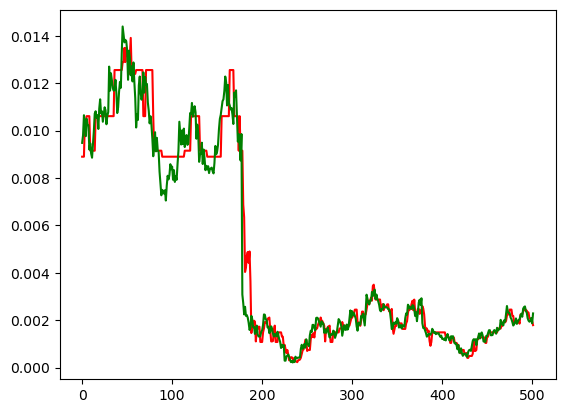

In [44]:
# 예측
cat_predictions = Cat_model.predict(stacked_pred_test)

# 성능 평가 (예: 가중평균앙상블)
mse = mean_squared_error(y_test, cat_predictions)
print("Stacking Ensemble MSE:", mse)

from matplotlib import pyplot as plt
pred_test = cat_predictions
plt.plot(pred_test,'r') 
plt.plot(y_test,'g')     

In [48]:
cat_predictions

array([0.00889693, 0.00889693, 0.00889693, 0.010354  , 0.010354  ,
       0.01060753, 0.01060753, 0.01060753, 0.01060753, 0.00915046,
       0.00915046, 0.00915046, 0.00915046, 0.00915046, 0.00915046,
       0.01060753, 0.01060753, 0.01060753, 0.01060753, 0.01060753,
       0.01060753, 0.01060753, 0.01060753, 0.01060753, 0.01060753,
       0.01060753, 0.01060753, 0.01060753, 0.01060753, 0.01060753,
       0.01060753, 0.01060753, 0.01060753, 0.01060753, 0.01060753,
       0.01060753, 0.01255325, 0.01255325, 0.01255325, 0.01255325,
       0.01255325, 0.01255325, 0.01255325, 0.01255325, 0.01255325,
       0.01288989, 0.01288989, 0.01348718, 0.01288989, 0.01348718,
       0.01313587, 0.01313587, 0.01239148, 0.01313587, 0.01390876,
       0.01245105, 0.01239148, 0.01239148, 0.01239148, 0.01239148,
       0.01255325, 0.01255325, 0.01255325, 0.01255325, 0.01255325,
       0.01255325, 0.01255325, 0.01255325, 0.01060753, 0.01060753,
       0.01060753, 0.01255325, 0.01255325, 0.01255325, 0.01255

# 하이퍼파라미터튜닝없이 그냥 캣부스트학습

In [46]:
# CatBoost 모델 초기화
catboost_model = CatBoostRegressor()

# 스태킹된 예측 결과를 사용하여 CatBoost 모델 학습
catboost_model.fit(stacked_predictions, y_train)

# CatBoost 모델을 사용하여 최종 예측 수행
final_predictions = catboost_model.predict(stacked_pred_test)

Learning rate set to 0.051961
0:	learn: 0.2119794	total: 1.59ms	remaining: 1.59s
1:	learn: 0.2015239	total: 3.05ms	remaining: 1.52s
2:	learn: 0.1914464	total: 4.22ms	remaining: 1.4s
3:	learn: 0.1821412	total: 5.3ms	remaining: 1.32s
4:	learn: 0.1731698	total: 6.49ms	remaining: 1.29s
5:	learn: 0.1645461	total: 9.93ms	remaining: 1.65s
6:	learn: 0.1564870	total: 14.7ms	remaining: 2.09s
7:	learn: 0.1487042	total: 15.5ms	remaining: 1.93s
8:	learn: 0.1414033	total: 18.1ms	remaining: 2s
9:	learn: 0.1344835	total: 18.8ms	remaining: 1.86s
10:	learn: 0.1279420	total: 19.5ms	remaining: 1.75s
11:	learn: 0.1217967	total: 20.2ms	remaining: 1.66s
12:	learn: 0.1157971	total: 20.9ms	remaining: 1.58s
13:	learn: 0.1101673	total: 21.5ms	remaining: 1.51s
14:	learn: 0.1048308	total: 22.1ms	remaining: 1.45s
15:	learn: 0.0996959	total: 22.8ms	remaining: 1.4s
16:	learn: 0.0948228	total: 23.4ms	remaining: 1.35s
17:	learn: 0.0901827	total: 23.9ms	remaining: 1.31s
18:	learn: 0.0858471	total: 24.6ms	remaining: 1.27

294:	learn: 0.0057614	total: 192ms	remaining: 460ms
295:	learn: 0.0057590	total: 193ms	remaining: 459ms
296:	learn: 0.0057582	total: 194ms	remaining: 458ms
297:	learn: 0.0057567	total: 194ms	remaining: 458ms
298:	learn: 0.0057559	total: 195ms	remaining: 457ms
299:	learn: 0.0057521	total: 195ms	remaining: 456ms
300:	learn: 0.0057510	total: 196ms	remaining: 455ms
301:	learn: 0.0057496	total: 197ms	remaining: 454ms
302:	learn: 0.0057473	total: 197ms	remaining: 454ms
303:	learn: 0.0057448	total: 198ms	remaining: 453ms
304:	learn: 0.0057412	total: 198ms	remaining: 452ms
305:	learn: 0.0057397	total: 199ms	remaining: 451ms
306:	learn: 0.0057365	total: 200ms	remaining: 451ms
307:	learn: 0.0057342	total: 200ms	remaining: 450ms
308:	learn: 0.0057315	total: 201ms	remaining: 449ms
309:	learn: 0.0057288	total: 201ms	remaining: 448ms
310:	learn: 0.0057267	total: 202ms	remaining: 447ms
311:	learn: 0.0057254	total: 203ms	remaining: 447ms
312:	learn: 0.0057233	total: 203ms	remaining: 446ms
313:	learn: 

615:	learn: 0.0054564	total: 387ms	remaining: 241ms
616:	learn: 0.0054562	total: 388ms	remaining: 241ms
617:	learn: 0.0054558	total: 389ms	remaining: 240ms
618:	learn: 0.0054552	total: 389ms	remaining: 240ms
619:	learn: 0.0054551	total: 390ms	remaining: 239ms
620:	learn: 0.0054547	total: 390ms	remaining: 238ms
621:	learn: 0.0054543	total: 391ms	remaining: 238ms
622:	learn: 0.0054542	total: 391ms	remaining: 237ms
623:	learn: 0.0054535	total: 392ms	remaining: 236ms
624:	learn: 0.0054529	total: 393ms	remaining: 236ms
625:	learn: 0.0054528	total: 393ms	remaining: 235ms
626:	learn: 0.0054524	total: 394ms	remaining: 234ms
627:	learn: 0.0054520	total: 394ms	remaining: 234ms
628:	learn: 0.0054516	total: 395ms	remaining: 233ms
629:	learn: 0.0054511	total: 396ms	remaining: 232ms
630:	learn: 0.0054505	total: 396ms	remaining: 232ms
631:	learn: 0.0054500	total: 397ms	remaining: 231ms
632:	learn: 0.0054496	total: 397ms	remaining: 230ms
633:	learn: 0.0054495	total: 398ms	remaining: 230ms
634:	learn: 

950:	learn: 0.0053591	total: 582ms	remaining: 30ms
951:	learn: 0.0053588	total: 583ms	remaining: 29.4ms
952:	learn: 0.0053587	total: 584ms	remaining: 28.8ms
953:	learn: 0.0053585	total: 584ms	remaining: 28.2ms
954:	learn: 0.0053584	total: 585ms	remaining: 27.6ms
955:	learn: 0.0053582	total: 586ms	remaining: 26.9ms
956:	learn: 0.0053576	total: 586ms	remaining: 26.3ms
957:	learn: 0.0053574	total: 587ms	remaining: 25.7ms
958:	learn: 0.0053570	total: 587ms	remaining: 25.1ms
959:	learn: 0.0053567	total: 588ms	remaining: 24.5ms
960:	learn: 0.0053563	total: 589ms	remaining: 23.9ms
961:	learn: 0.0053559	total: 589ms	remaining: 23.3ms
962:	learn: 0.0053556	total: 590ms	remaining: 22.7ms
963:	learn: 0.0053555	total: 591ms	remaining: 22.1ms
964:	learn: 0.0053553	total: 591ms	remaining: 21.4ms
965:	learn: 0.0053551	total: 592ms	remaining: 20.8ms
966:	learn: 0.0053549	total: 592ms	remaining: 20.2ms
967:	learn: 0.0053545	total: 593ms	remaining: 19.6ms
968:	learn: 0.0053543	total: 594ms	remaining: 19

Stacking Ensemble MSE: 8.395150225499395e-07


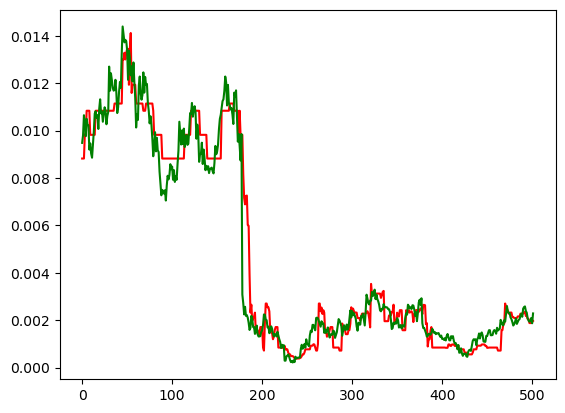

In [47]:

# 성능 평가 (예: 가중평균앙상블)
mse = mean_squared_error(y_test, final_predictions)
print("Stacking Ensemble MSE:", mse)

from matplotlib import pyplot as plt
pred_test = final_predictions
plt.plot(pred_test,'r') 
plt.plot(y_test,'g')     